This notebook munges the accuracy and $F_1$ values for the subtype classification task and makes several visualizations.

In [1]:
import getpass
import itertools as itt
import sys
import time

import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kruskal, mannwhitneyu

from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols

In [2]:
%matplotlib inline

In [3]:
mpl.rcParams['figure.dpi'] = 200

In [4]:
print(getpass.getuser())

sarah


In [5]:
print(sys.version)

3.6.5 |Anaconda, Inc.| (default, Apr 29 2018, 16:14:56) 
[GCC 7.2.0]


In [6]:
print(time.asctime())

Sat May 25 23:03:02 2019


In [7]:
df = pd.read_csv('../../input/subtype_classification_results.tsv', sep='\t')
df = df.sort_values(['Database', 'Dataset'])
df.head()

,Database,Dataset,Metric,Measurement
0,KEGG,BRCA,Accuracy,0.876190
1,KEGG,BRCA,Accuracy,0.914286
2,KEGG,BRCA,Accuracy,0.904762
3,KEGG,BRCA,Accuracy,0.895238
4,KEGG,BRCA,Accuracy,0.847619


In [8]:
accuracy_df = df.loc[df['Metric'] == 'Accuracy']

Test whether on average all databases perform equally

In [9]:
formula = 'Measurement ~ Database*Dataset'
model = ols(formula, accuracy_df).fit()
aov_table = anova_lm(model, typ=2)
print(aov_table)

                    sum_sq     df          F        PR(>F)
Database          0.029775    5.0   1.635255  1.567997e-01
Dataset           0.217715    1.0  59.783976  5.885679e-12
Database:Dataset  0.003822    5.0   0.209910  9.576764e-01
Residual          0.393303  108.0        NaN           NaN


In [10]:
accuracy_df = df[df.Metric == 'Accuracy']
del accuracy_df['Metric']
accuracy_df.columns = ['Database', 'Dataset', 'Accuracy']

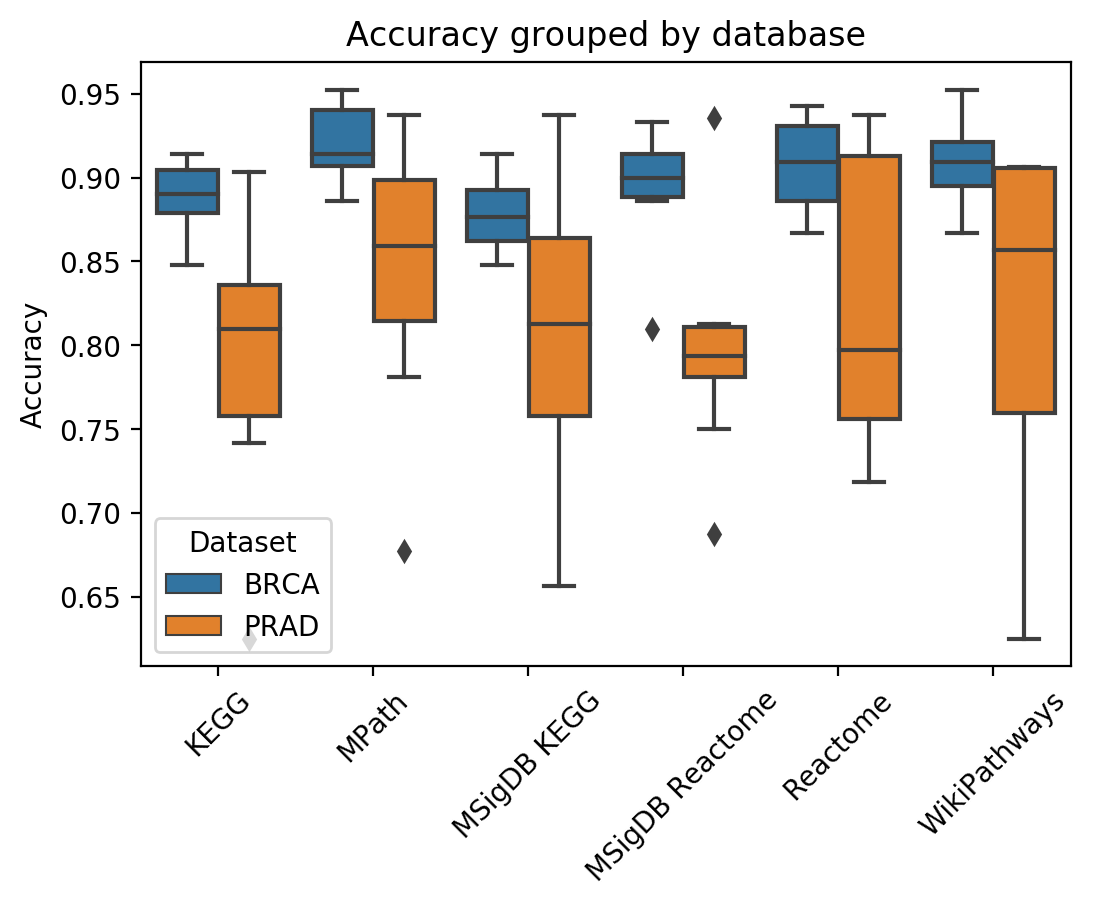

In [11]:
ax = sns.boxplot(
    y='Accuracy',
    x='Database',
    hue='Dataset',
    data=accuracy_df,
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.xlabel('')
plt.title('Accuracy grouped by database')
plt.show()

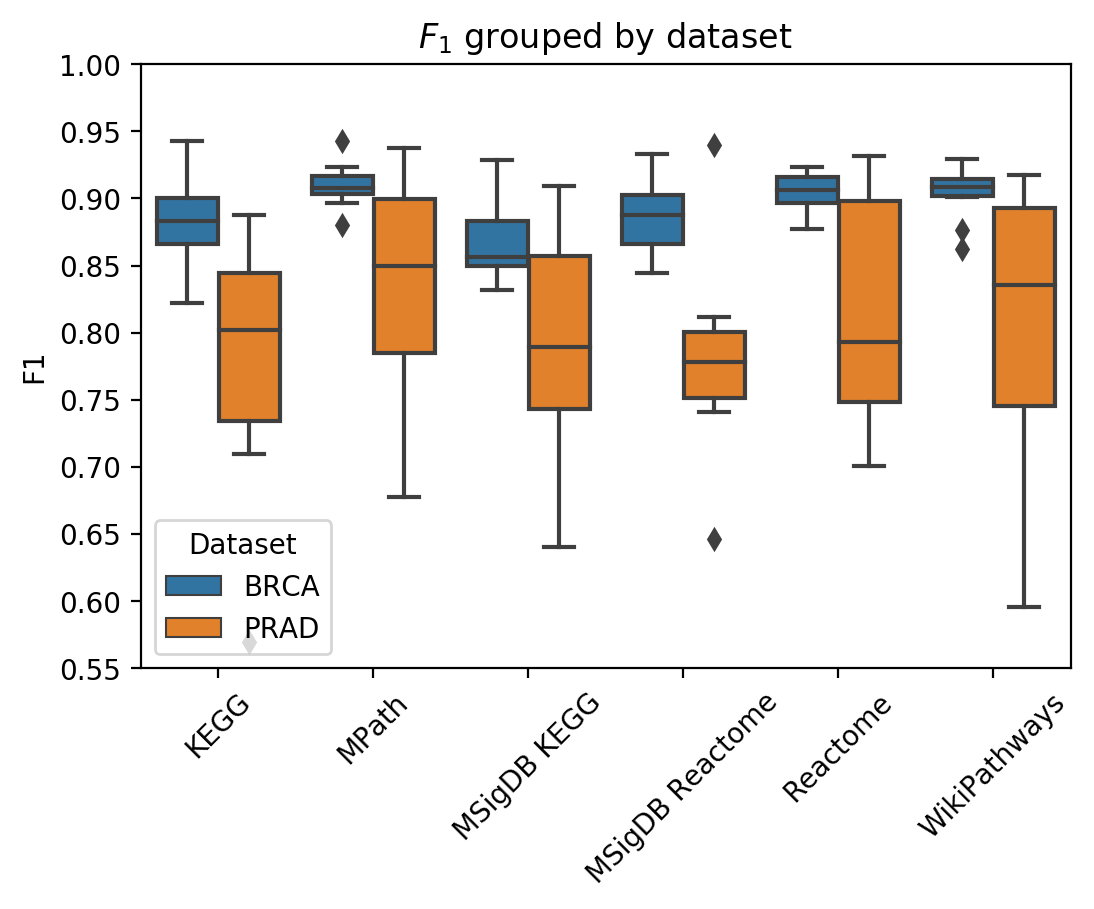

In [12]:
f1_df = df[df.Metric == 'F1']
del f1_df['Metric']
f1_df.columns = ['Database', 'Dataset', 'F1']

ax = sns.boxplot(
    y='F1',
    x='Database',
    hue='Dataset',
    data=f1_df
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_ylim([0.55,1])
plt.xlabel('')
plt.title('$F_1$ grouped by dataset')
plt.show()

In [13]:
hue_order = ['KEGG', 'Reactome', 'WikiPathways', 'MSigDB KEGG', 'MSigDB Reactome', 'MPath']

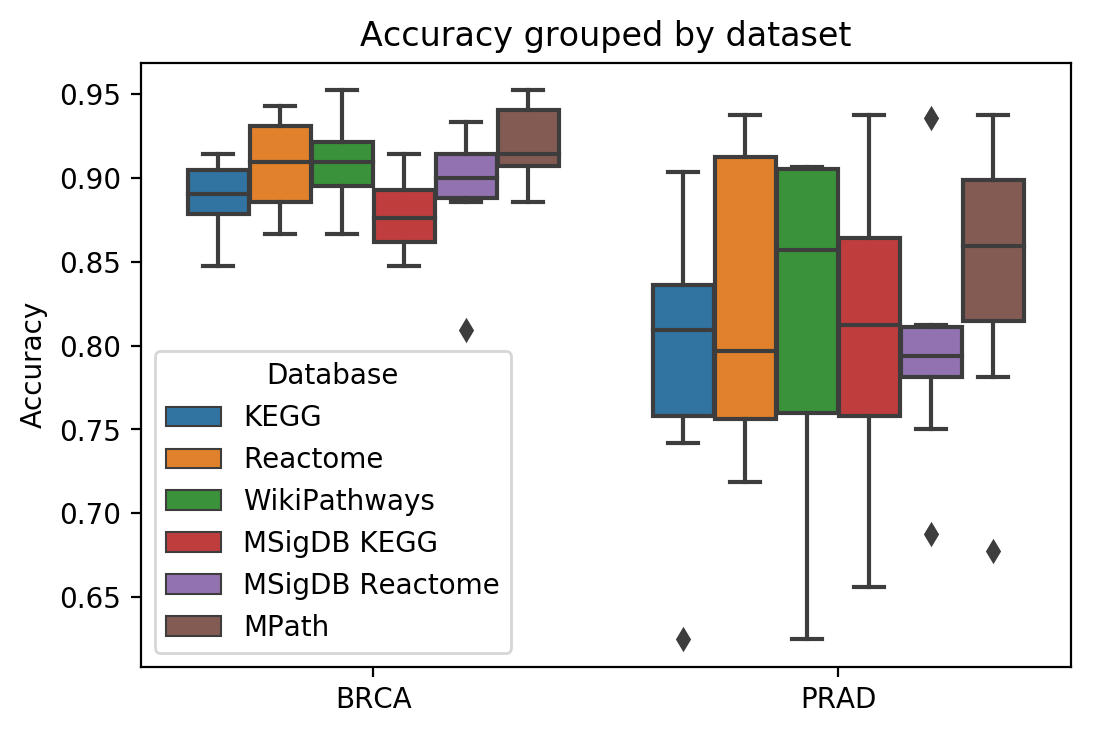

In [14]:
ax = sns.boxplot(
    y='Accuracy',
    x='Dataset',
    hue='Database',
    data=accuracy_df,
    hue_order=hue_order,
)
plt.xlabel('')
plt.title('Accuracy grouped by dataset')
plt.show()

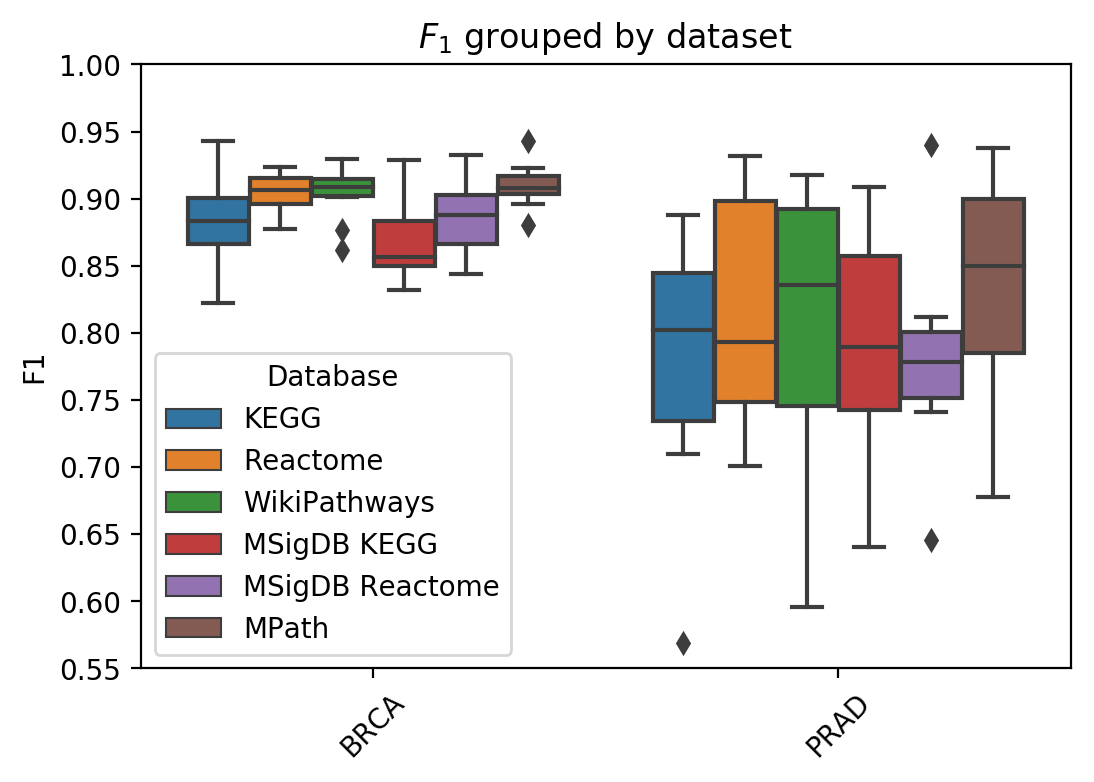

In [15]:
ax = sns.boxplot(
    y='F1',
    x='Dataset',
    hue='Database',
    data=f1_df,
    hue_order=hue_order,
)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_ylim([0.55,1])
plt.xlabel('')
plt.title('$F_1$ grouped by dataset')
plt.show()

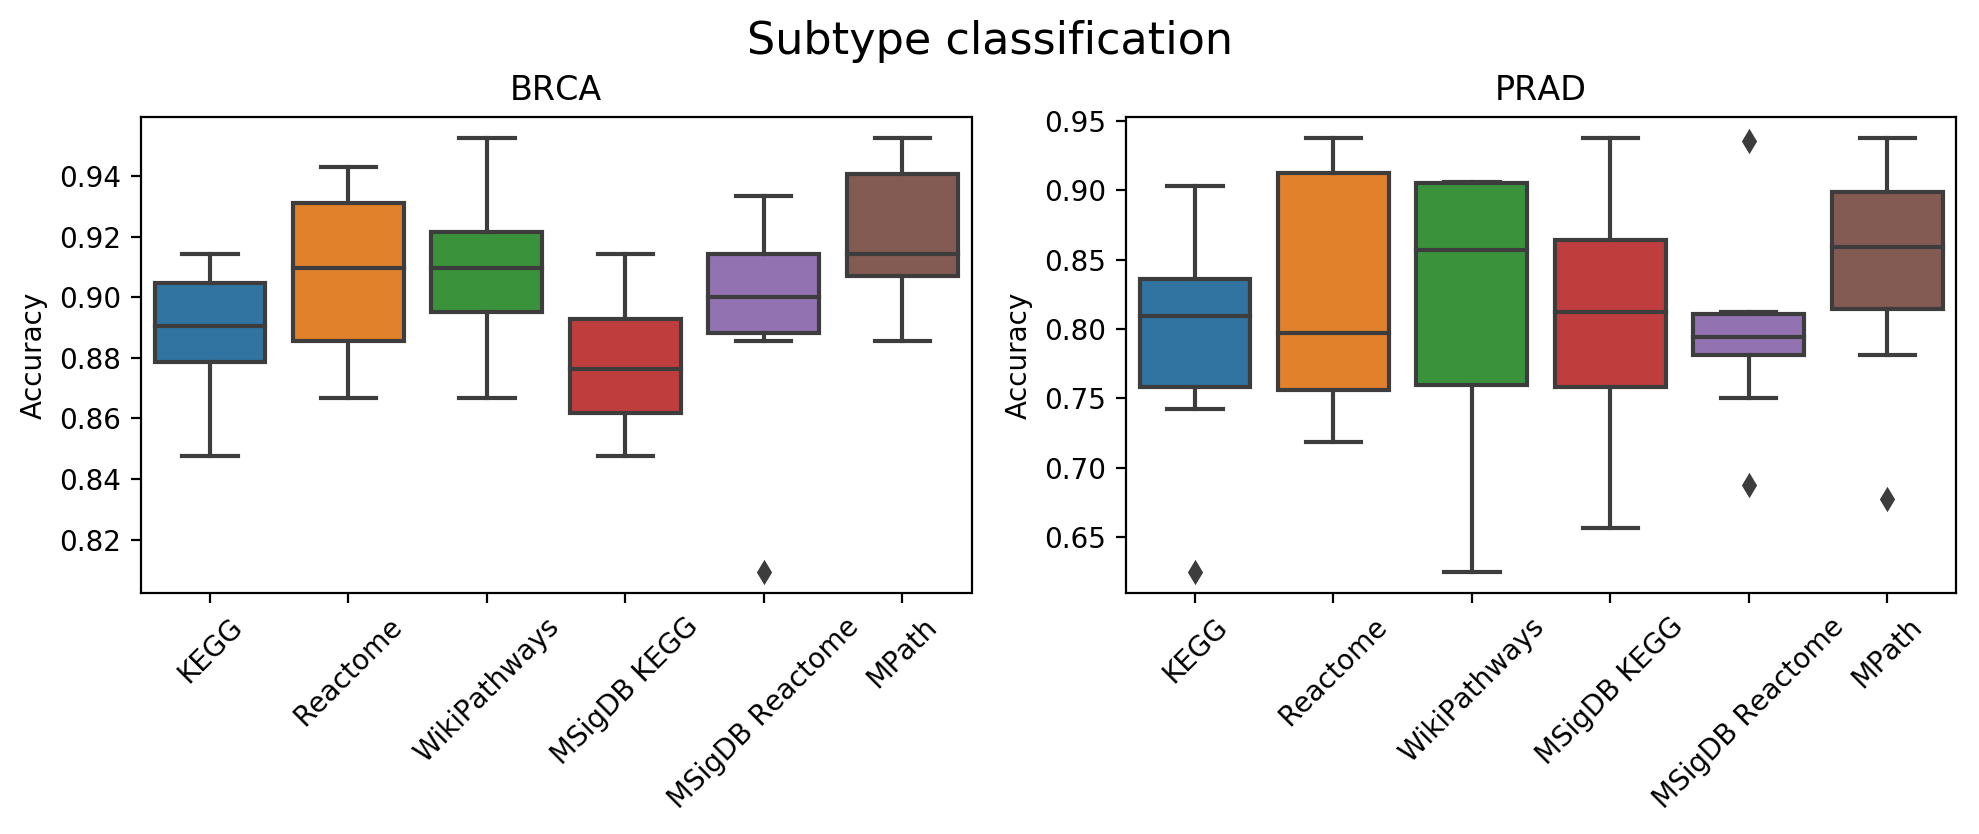

In [16]:
fig = plt.figure(figsize=(10, 4)) 

ax1 = plt.subplot2grid(shape=(1,2), loc=(0,0), colspan=1)
ax2 = plt.subplot2grid((1,2), (0,1), colspan=1)

plt.suptitle('Subtype classification', fontsize=16, y=1.03)

for dataset, ax in zip(df['Dataset'].unique(), [ax1, ax2]):
    ax.set_title(dataset)
    # Use this to make the y-axes all use the same, but makes readability difficult
    # ax.set_ylim(bottom=y_min, top=1.0)  
    sns.boxplot(
        y='Accuracy',
        x='Database',
        data=accuracy_df[accuracy_df['Dataset'] == dataset],
        order=hue_order,
        ax=ax,
    )
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    ax.set_xlabel('')

plt.tight_layout()
plt.show()

## Assessing the significance of the classifiers for BRCA

In [17]:
# Filter dataframe to BRCA and group by database the rows
accuracy_dict = accuracy_df[accuracy_df['Dataset'] == 'BRCA'].groupby('Database')['Accuracy'].apply(list)

stats, p_value = kruskal(
    accuracy_dict['KEGG'],
    accuracy_dict['Reactome'],
    accuracy_dict['WikiPathways'],
    accuracy_dict['MPath'],
    accuracy_dict['MSigDB KEGG'],
    accuracy_dict['MSigDB Reactome'],
)

Assessing whether there are differences across all pathway resources 

In [18]:
p_value

0.013878379935605341

Assessing whether there are differences between the Merge dataset (the most predictive one) and Reactome (the second most predictive one)

In [19]:
stats, p_value = mannwhitneyu(accuracy_dict['MPath'], accuracy_dict['Reactome'])

In [20]:
p_value

0.1350678462330951

Assessing whether there are differences between the Merge dataset (the most predictive one) and KEGG (the fourth most predictive one)

In [21]:
stats, p_value = mannwhitneyu(accuracy_dict['MPath'], accuracy_dict['KEGG'])

In [22]:
p_value

0.005814863332948633

**Note that the *p*-value is even more significant for MSigDB KEGG and MSigDB Reactome. **

In [23]:
pd.DataFrame(
    [
        [
            mannwhitneyu(accuracy_dict[a], accuracy_dict[b])[1] # p-value is second in tuple
            for a in hue_order
        ]
        for b in hue_order
    ],
    index=hue_order,
    columns=hue_order,
)

,KEGG,Reactome,WikiPathways,MSigDB KEGG,MSigDB Reactome,MPath
KEGG,0.484729,0.097941,0.068586,0.134062,0.151172,0.005815
Reactome,0.097941,0.484729,0.454623,0.018174,0.337461,0.135068
WikiPathways,0.068586,0.454623,0.484729,0.012294,0.283616,0.199703
MSigDB KEGG,0.134062,0.018174,0.012294,0.484634,0.028537,0.001023
MSigDB Reactome,0.151172,0.337461,0.283616,0.028537,0.484729,0.050034
MPath,0.005815,0.135068,0.199703,0.001023,0.050034,0.484634
